# Two Stream Instability PIC  Simulation

### What is PIC?

### What is a "two stream instability"?

### Time For The Simulation!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

In [2]:
# Definition of simulation parameters.

# Number of particles.
N_part = 40000
# Number of mesh cells.
N_mesh = 400
# Simulation duration.
t = 50
# Time step.
dt = 0.5
# Size of the periodic box.
box_size = 50
# Size of each cell.
dx = box_size / N_mesh
# Electron number density.
n_0 = 1
# Velocity constant for the Gaussian beams.
b_vel = 3
# Width constant for the Gaussian beams.
b_wd = 1
# Perturbation.
P = 0.1

In [3]:
# Definition of the initial conditions.

# Seed for the random number generator, in case we need to replicate our results.
np.random.seed(42)
# Create two Gaussian beams (consisting of electrons) moving opposite to each other.

#The np.random.rand(R, C) is used to create a RxC matrix consisting of random numbers in range 0 and 1.
# Define a Nx1 random matrix for ALL particle positions.
pos_part = np.random.rand(N_part, 1) * box_size
# Define a Nx1 random matrix for ALL particle velocities.
vel_part = b_wd * np.random.randn(N_part, 1) + b_vel
# Number of particles of each beam.
N_b = int(N_part/2)
# Revert the sign of half of the particle velocities, thus creating two beams opposite to each other.
vel_part[N_b:] *= -1
# Add perturbation to particle velocities.
vel_part *= (1 + P*np.sin(2*np.pi*pos_part/box_size))

### Gradient and Laplacian Calculations With Matrix Representations
In order to compute the Gradient and Laplacian, we need to perform numerical differentiation. 
***
For the gradient calculation, I will be using the "first order central difference method"; which is $ y'(x) ≈ (y(x + ∆x) - y(x - ∆x)) / 2∆x $.
***
For the Laplacian calculation, I will be using the "second order central difference method"; which is $ y''(x) ≈ (y(x + ∆x) - 2y(x) + y(x - ∆x)) / ∆x^2 $.
***
I can iterate over all the points we just defined and carry out the differentiation one by one, however I will use a different approach which I have just found out. Matrix representation! 
***
Matrix representation of the first order central difference method is
$$ 
\begin{pmatrix}
y'_1 \\ y'_2 \\ ... \\ y'_N 
\end{pmatrix}
≈ (1 / 2∆x) 
\begin{pmatrix}
-1 & 0 & 1 & ...\\ ... & ... & ... & ... \\ ... & ... & ... & ... \\ ... & -1 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
y_0 \\ y_1 \\ ... \\ y_N+_1
\end{pmatrix}
$$

Matrix representation of the second order central difference method is
$$ 
\begin{pmatrix}
y''_1 \\ y''_2 \\ ... \\ y''_N 
\end{pmatrix}
≈ (1 / ∆x^2) 
\begin{pmatrix}
1 & -2 & 1 & ...\\ ... & ... & ... & ... \\ ... & ... & ... & ... \\ ... & 1 & -2 & 1
\end{pmatrix}
\begin{pmatrix}
y_0 \\ y_1 \\ ... \\ y_N+_1
\end{pmatrix}
$$
which honestly just blew my mind!
***
Python is really good in terms of its readibility but it suffers in the speed department for sure... Iterating over each element in a simulation is never a good choice, matrix operations carried out by the "Numpy" module will always be faster! Therefore, this matrix representation will allow us to use matrix operations instead of loop iterations!

In [4]:
# Construct matrix G to compute the Gradient  (1st derivative)
e = np.ones(N_mesh)
diags = np.array([-1,1])
vals  = np.vstack((-e,e))
Gmtx = sp.spdiags(vals, diags, N_mesh, N_mesh);
Gmtx = sp.lil_matrix(Gmtx)
Gmtx[0,N_mesh-1] = -1
Gmtx[N_mesh-1,0] = 1
Gmtx /= (2*dx)
Gmtx = sp.csr_matrix(Gmtx)

In [5]:
# Construct matrix L to computer Laplacian (2nd derivative)
diags = np.array([-1,0,1])
vals  = np.vstack((e,-2*e,e))
Lmtx = sp.spdiags(vals, diags, N_mesh, N_mesh);
Lmtx = sp.lil_matrix(Lmtx)
Lmtx[0,N_mesh-1] = 1
Lmtx[N_mesh-1,0] = 1
Lmtx /= dx**2
Lmtx = sp.csr_matrix(Lmtx)

### Solving the Equations Of Motion

In [6]:
def calcAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
    """
    Calculate the acceleration on each particle due to electric field
    pos      is an Nx1 matrix of particle positions
    Nx       is the number of mesh cells
    boxsize  is the domain [0,boxsize]
    n0       is the electron number density
    Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
    Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
    a        is an Nx1 matrix of accelerations
    """
    # Calculate Electron Number Density on the Mesh by 
    # placing particles into the 2 nearest bins (j & j+1, with proper weights)
    # and normalizing
    N          = pos.shape[0]
    dx         = boxsize / Nx
    j          = np.floor(pos/dx).astype(int)
    jp1        = j+1
    weight_j   = ( jp1*dx - pos  )/dx
    weight_jp1 = ( pos    - j*dx )/dx
    jp1        = np.mod(jp1, Nx)   # periodic BC
    n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
    n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
    n *= n0 * boxsize / N / dx 

    # Solve Poisson's Equation: laplacian(phi) = n-n0
    phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
    
    # Apply Derivative to get the Electric field
    E_grid = - Gmtx @ phi_grid
    
    # Interpolate grid value onto particle locations
    E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
    
    a = -E

    return a

### Integration And The Result

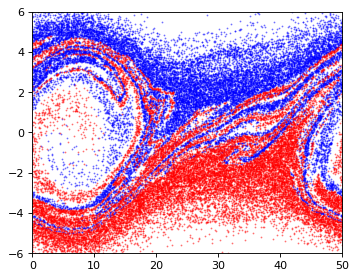

In [9]:
# calculate initial gravitational accelerations
acc_part = calcAcc(pos_part, N_mesh, box_size, n_0, Gmtx, Lmtx)

# prep figure
fig = plt.figure(figsize=(5, 4), dpi=80)
ax = fig.add_subplot(111)
# Simulation Main Loop
for i in range(int(t/dt)):
    # (1/2) kick
    vel_part += acc_part * dt/2.0
    
    # drift (and apply periodic boundary conditions)
    pos_part += vel_part * dt
    pos_part = np.mod(pos_part, box_size)
    
    # update accelerations
    acc_part = calcAcc(pos_part, N_mesh, box_size, n_0, Gmtx, Lmtx)
    
    # (1/2) kick
    vel_part += acc_part * dt/2.0
    
    # plot in real time - color 1/2 particles blue, other half red
    ax.cla()
    ax.scatter(pos_part[0:N_b],vel_part[0:N_b],s=.4,color='blue', alpha=0.5)
    ax.scatter(pos_part[N_b:], vel_part[N_b:], s=.4,color='red',  alpha=0.5)
    ax.axis([0,box_size,-6,6])
    display(fig)
    
    clear_output(wait = True)
    #plt.pause(0.05)